C:\Users\Paulina\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


XGBoost train score: 0.89697265625
XGBoost valid score: 0.842421875
train gain=0.746471728909653
valid gain=0.022601621597313944


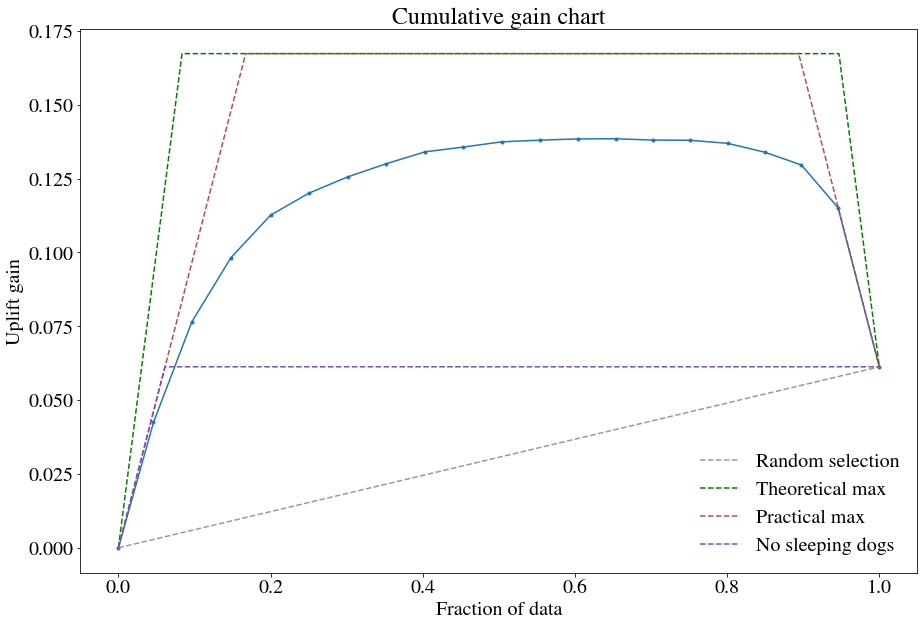

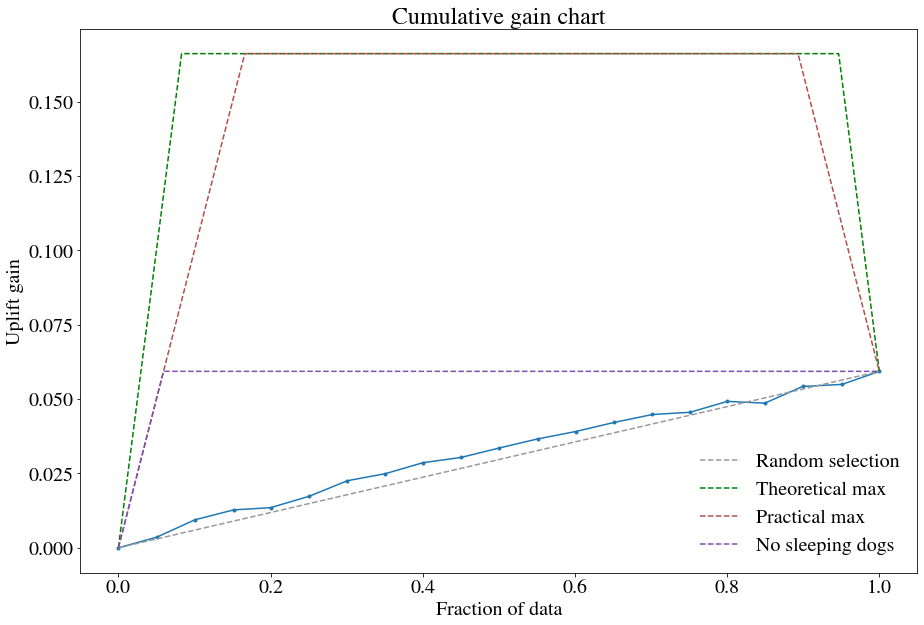

In [2]:
import shap
from data import X_train, Y_train, X_valid, Y_valid, treatment_col, column_names
from model import train_xgb_model, train_logistic, simple_network, evaluate_uplift
from pylift.eval import UpliftEval
import matplotlib

xgbmodel = train_xgb_model(X_train, Y_train, X_valid, Y_valid)

#upev = UpliftEval(X_valid[:, treatment_col], xgbmodel.predict_proba(treatment_col))
#nmodel = simple_network(X_train, Y_train, X_valid, Y_valid)
#logmodel = train_logistic(X_train, Y_train, X_valid, Y_valid)


# plot importance
#explainer = shap.TreeExplainer(xgbmodel)
#xg_shap_values = explainer.shap_values(X_train.iloc[:100, :])
#shap.force_plot(explainer.expected_value, xg_shap_values[0, :], X_train.iloc[0, :], matplotlib=True)
#shap.summary_plot(xg_shap_values, X_train.iloc[:100, :], feature_names=list(X_train.columns))

print("train gain={}".format(evaluate_uplift(xgbmodel, X_train, Y_train, treatment_col, plot=True)))
print("valid gain={}".format(evaluate_uplift(xgbmodel, X_valid, Y_valid, treatment_col, plot=True)))

# Shapley

In [116]:
xgbmodel_predict=lambda x: xgbmodel.predict_proba(x)[:,1]

In [117]:
import numpy as np
np.random.seed(123)

In [ ]:
# obserwacja nr 2
obs2 = X_valid[2,:]

In [132]:
def shapley_single (model_predict, obs):
    explainer = shap.KernelExplainer(xgbmodel_predict, shap.sample(X_valid, 100))
    #shap.TreeExplainer(xgbmodel, model_output='probability', data=shap.sample(X_valid,100))
    shap_values = explainer.shap_values(obs) 
    plot = shap.waterfall_plot(explainer.expected_value, shap_values,
                                   feature_names=column_names)
    return shap_values

In [133]:
def shapley_diff(model_predict, obs):
    obs_T0=obs.copy()
    obs_T0[-1]=0
    
    obs_T1=obs.copy()
    obs_T1[-1]=1
    
    shap_T0=shapley_single(model_predict, obs_T0)
    shap_T1=shapley_single(model_predict, obs_T1)
    
    return shap_T1-shap_T0

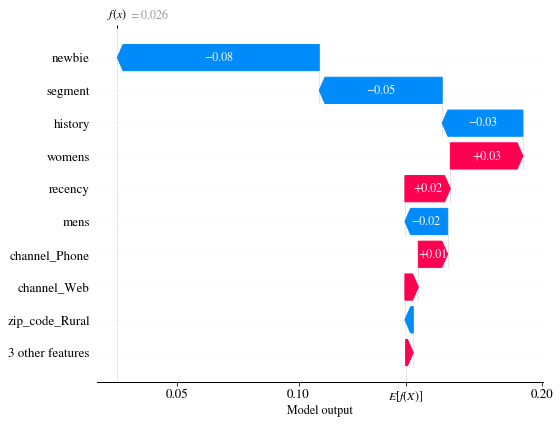

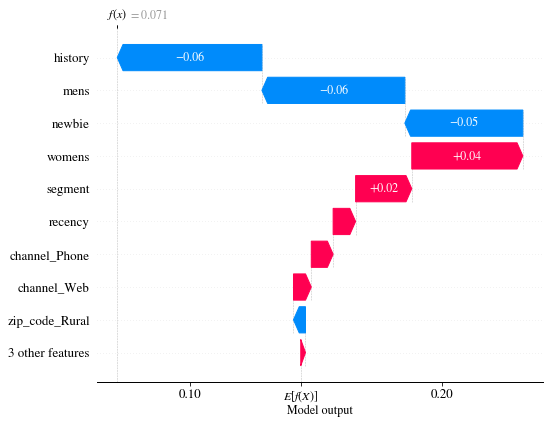

array([-0.00973476, -0.0242849 , -0.03917513,  0.01430485, -0.00301866,
       -0.00133085,  0.00193465,  0.03603955, -0.00334279,  0.00154111,
       -0.00015987,  0.07274292])

In [142]:
shapley_diff(xgbmodel_predict, obs2)

# Uplift model

In [139]:
def uplift(model, x, treatment_col=treatment_col):
    x_ones = x.copy()
    x_zeros = x.copy()
    x_ones[:, treatment_col] = 1
    x_zeros[:, treatment_col] = 0

    uplift = (model.predict_proba(x_ones) - model.predict_proba(x_zeros))[:, 1]
    return uplift

In [140]:
uplift_predict=lambda x: uplift(xgbmodel, x).astype(float)

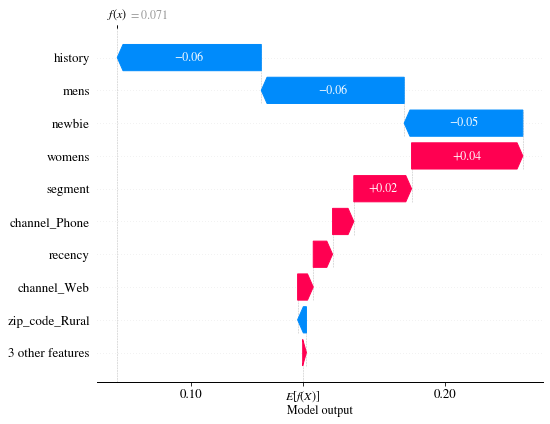

array([ 0.00758221, -0.056554  , -0.05611102,  0.04368918,  0.00063674,
       -0.00346267,  0.00132367, -0.04657508,  0.00834342,  0.00614317,
       -0.00049953,  0.02267263])

In [141]:
shapley_single(uplift_predict, obs2)

# issues:
- shapley values in the two methods are different